# Assess Replicate Correlation

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggridges))

In [2]:
set.seed(123)

## Step 0: Load Constants

In [3]:
batch_id <- "2019_08_06_Batch3"
backend_dir <- file.path("..", "..", "backend", batch_id)

## Step 1: Read in Normalized Profiles

In [4]:
profile_files <- list.files(backend_dir,
                            full.names = TRUE,
                            recursive = TRUE,
                            pattern = "_variable_selected.csv")

In [5]:
profile_cols <- readr::cols(
  .default = readr::col_double(),
  Metadata_Plate = readr::col_character(),
  Metadata_Well = readr::col_character(),
  Metadata_Assay_Plate_Barcode = readr::col_character(),
  Metadata_Plate_Map_Name = readr::col_character(),
  Metadata_well_position = readr::col_character(),
  Metadata_cell_line = readr::col_character(),
  Metadata_condition_O2 = readr::col_character()
)

In [6]:
profile_df <- purrr::map_df(
    profile_files,
    readr::read_csv,
    col_types = readr::cols()
)

dim(profile_df)
head(profile_df, 2)

[1] 320 381

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,Cells_AreaShape_Eccentricity,⋯,Nuclei_Texture_InfoMeas1_ER_5_02,Nuclei_Texture_InfoMeas1_ER_5_03,Nuclei_Texture_InfoMeas1_Mito_5_02,Nuclei_Texture_InfoMeas2_AGP_5_00,Nuclei_Texture_InfoMeas2_DNA_5_02,Nuclei_Texture_InfoMeas2_ER_5_00,Nuclei_Texture_SumAverage_DNA_20_03,Nuclei_Texture_SumEntropy_DNA_20_01,Nuclei_Texture_SumVariance_AGP_5_02,Nuclei_Texture_SumVariance_DNA_5_01
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D14,A01,D14,D14,A01,sc,252,0,14,0.6306623,⋯,-2.1257432,-2.6656060,-2.35608270,0.6827143,-0.7255571,1.8657687,-2.8262159,-3.226772,-0.09036726,0.1492228
D14,A02,D14,D14,A02,vc,252,0,14,0.3142997,⋯,-0.5040411,-0.8457348,0.01165808,0.1356248,-0.7532221,0.7095039,0.6778517,1.411267,0.19333425,-0.6120955


In [7]:
# Output Combined Profiles
file <- file.path("data", paste0("merged_profiles_", batch_id, ".tsv.gz"))
readr::write_tsv(profile_df, file)

## Step 2: Extract Pairwise Correlations

In [8]:
# Separate different cell profiler data
cp_features <- colnames(profile_df) %>%
    stringr::str_subset("^Nuclei_|^Cells_|^Cytoplasm_")

length(cp_features)

cp_metadata <- colnames(profile_df) %>%
    stringr::str_subset("^Metadata_")

length(cp_metadata)

[1] 372

[1] 9

In [9]:
# Create a metadata dictionary and dummy variable "group_id"
# "group_id" distinguishes each separate condition including cell line
# "condition_group_id" distinguishes separate conditions ignoring cell line
metadata_df <- profile_df %>%
    dplyr::select(cp_metadata) %>%
    dplyr::mutate(dictionary_id = paste0("id_", dplyr::row_number()),
                  group_id = group_indices(.,
                                           Metadata_cell_line,
                                           Metadata_patient,
                                           Metadata_FFA,
                                           Metadata_diff_day))

tail(metadata_df)

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,dictionary_id,group_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<int>
Day8,H06,Day8,Day8,H06,sc,270,1,8,id_315,23
Day8,H07,Day8,Day8,H07,vc,270,1,8,id_316,63
Day8,H08,Day8,Day8,H08,sc,272,1,8,id_317,31
Day8,H09,Day8,Day8,H09,vc,272,1,8,id_318,71
Day8,H10,Day8,Day8,H10,sc,276,1,8,id_319,39
Day8,H11,Day8,Day8,H11,vc,276,1,8,id_320,79


In [10]:
table(metadata_df$Metadata_diff_day)


 0  3  8 14 
80 80 80 80 

## Metadata Description

* `Cell Line`
  * `vc` is visceral pre-adipocytes
  * `sc` is subcutaneous pre-adipocytes
* `Patient` - There are 6 patients
  * 214
  * 252
  * 270
  * 272
  * 276
* Free Fatty Acids (`FFA`)
  * With or without condition
* `Day`
  * 4 different days - 0, 3, 8

In [11]:
table(
    metadata_df$Metadata_diff_day,
    metadata_df$Metadata_patient,
    metadata_df$Metadata_cell_line,
    metadata_df$Metadata_FFA
)

, ,  = sc,  = 0

    
     214 252 270 272 276
  0    4   4   4   4   5
  3    4   4   4   4   5
  8    4   4   4   4   5
  14   4   4   4   4   5

, ,  = vc,  = 0

    
     214 252 270 272 276
  0    4   4   4   4   3
  3    4   4   4   4   3
  8    4   4   4   4   3
  14   4   4   4   4   3

, ,  = sc,  = 1

    
     214 252 270 272 276
  0    4   4   4   4   4
  3    4   4   4   4   4
  8    4   4   4   4   4
  14   4   4   4   4   4

, ,  = vc,  = 1

    
     214 252 270 272 276
  0    4   4   4   4   4
  3    4   4   4   4   4
  8    4   4   4   4   4
  14   4   4   4   4   4


In [12]:
# Create a dataframe of variables for each group
group_id_df <- metadata_df %>%
    dplyr::select(
        group_id,
        Metadata_cell_line,
        Metadata_patient,
        Metadata_FFA,
        Metadata_diff_day
    ) %>%
    dplyr::distinct() %>%
    dplyr::arrange(group_id)

dim(group_id_df)
head(group_id_df)

[1] 80  5

group_id,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day
<int>,<chr>,<int>,<int>,<int>
1,sc,214,0,0
2,sc,214,0,3
3,sc,214,0,8
4,sc,214,0,14
5,sc,214,1,0
6,sc,214,1,3


## Step 3: Get Correlations

In [13]:
cor_df <- profile_df %>%
    dplyr::select(cp_features) %>%
    t() %>%
    cor() %>%
    dplyr::as_tibble() %>%
    magrittr::set_colnames(metadata_df$dictionary_id)

cor_melt_df <- metadata_df %>%
    dplyr::select(-group_id) %>%
    dplyr::bind_cols(
        replace(cor_df,
                lower.tri(cor_df, TRUE), NA)
    ) %>%
    dplyr::select(-cp_metadata) %>%
    reshape2::melt(id.vars = 'dictionary_id',
                   variable.name = 'correlation_id', 
                   value.name = "pearson_cor",
                   na.rm = TRUE) %>%
    tibble::remove_rownames()

dim(cor_melt_df)
head(cor_melt_df)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

[1] 51040     3

dictionary_id,correlation_id,pearson_cor
<chr>,<fct>,<dbl>
id_1,id_2,0.1923338
id_1,id_3,0.2382093
id_2,id_3,0.5216382
id_1,id_4,-0.1008443
id_2,id_4,0.5067394
id_3,id_4,0.4484064


In [14]:
# Map group IDs and condition IDs onto the correlation dataframe
# We are interested in correlations between specific groups
cor_group_df <- cor_melt_df %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id),
        by = 'dictionary_id'
    ) %>%
    dplyr::rename(pair_a = group_id) %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id),
        by = c('correlation_id' = 'dictionary_id')
    ) %>%
    dplyr::rename(pair_b = group_id,
                  pair_a_id = dictionary_id,
                  pair_b_id = correlation_id)

dim(cor_group_df)
head(cor_group_df)

Warning message:
“Column `correlation_id`/`dictionary_id` joining factor and character vector, coercing into character vector”

[1] 51040     5

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b
<chr>,<chr>,<dbl>,<int>,<int>
id_1,id_2,0.1923338,12,52
id_1,id_3,0.2382093,12,4
id_2,id_3,0.5216382,52,4
id_1,id_4,-0.1008443,12,44
id_2,id_4,0.5067394,52,44
id_3,id_4,0.4484064,4,44


In [15]:
# Remove self correlations and determine median correlation between all groups
# Also create a variable that represents correlations across cell lines within
# the same condition. This variable will be used as the null distribution.
cor_group_df <- cor_group_df %>%
    dplyr::mutate(
        within_group_cor =
            as.numeric(cor_group_df$pair_a == cor_group_df$pair_b),
    ) %>%
    dplyr::filter(cor_group_df$pair_a_id != cor_group_df$pair_b_id) %>%
    dplyr::group_by(
        pair_a,
        pair_b
    ) %>%
    dplyr::mutate(median_cor = median(pearson_cor)) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(median_cor))

dim(cor_group_df)
head(cor_group_df)

[1] 51040     7

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
id_127,id_136,-0.03737530,69,21,0,0.9999986
id_127,id_145,0.99999856,69,21,0,0.9999986
id_137,id_145,0.99999995,69,21,0,0.9999986
id_127,id_155,0.99999866,69,21,0,0.9999986
id_137,id_155,0.99999984,69,21,0,0.9999986
id_148,id_155,-0.01156788,69,21,0,0.9999986


In [16]:
# Join Replicate Correlations and Null Distribution Correlations
within_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 1) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

null_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 0) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Non Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

full_plot_ready <- within_group_cor_df %>%
    dplyr::bind_rows(
        null_group_cor_df
    )

dim(full_plot_ready)
head(full_plot_ready)

[1] 51040     9

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor,pair_b_median_cor,null_data
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
id_129,id_140,0.9999886,77,77,1,0.9999938,0.9999938,Replicate Correlation
id_129,id_150,0.9999990,77,77,1,0.9999938,0.9999938,Replicate Correlation
id_140,id_150,0.9999931,77,77,1,0.9999938,0.9999938,Replicate Correlation
id_129,id_160,0.9999901,77,77,1,0.9999938,0.9999938,Replicate Correlation
id_140,id_160,0.9999976,77,77,1,0.9999938,0.9999938,Replicate Correlation
id_150,id_160,0.9999945,77,77,1,0.9999938,0.9999938,Replicate Correlation


## Step 4: Generate Figures

In [17]:
# Merge plot ready data with info on group ID
full_plot_ready <- full_plot_ready %>%
    dplyr::left_join(group_id_df, by = c("pair_b" = "group_id"))

head(full_plot_ready, 2)

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor,pair_b_median_cor,null_data,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>
id_129,id_140,0.9999886,77,77,1,0.9999938,0.9999938,Replicate Correlation,vc,276,1,0
id_129,id_150,0.9999990,77,77,1,0.9999938,0.9999938,Replicate Correlation,vc,276,1,0


Picking joint bandwidth of 0.0949
Picking joint bandwidth of 0.101
Picking joint bandwidth of 0.0576
Picking joint bandwidth of 0.0379
Picking joint bandwidth of 0.109
Picking joint bandwidth of 0.127
Picking joint bandwidth of 0.154
Picking joint bandwidth of 0.171
Picking joint bandwidth of 0.0949
Picking joint bandwidth of 0.101
Picking joint bandwidth of 0.0576
Picking joint bandwidth of 0.0379
Picking joint bandwidth of 0.109
Picking joint bandwidth of 0.127
Picking joint bandwidth of 0.154
Picking joint bandwidth of 0.171
Picking joint bandwidth of 0.0949
Picking joint bandwidth of 0.101
Picking joint bandwidth of 0.0576
Picking joint bandwidth of 0.0379
Picking joint bandwidth of 0.109
Picking joint bandwidth of 0.127
Picking joint bandwidth of 0.154
Picking joint bandwidth of 0.171
Picking joint bandwidth of 0.0763
Picking joint bandwidth of 0.122
Picking joint bandwidth of 0.135
Picking joint bandwidth of 0.144
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.134


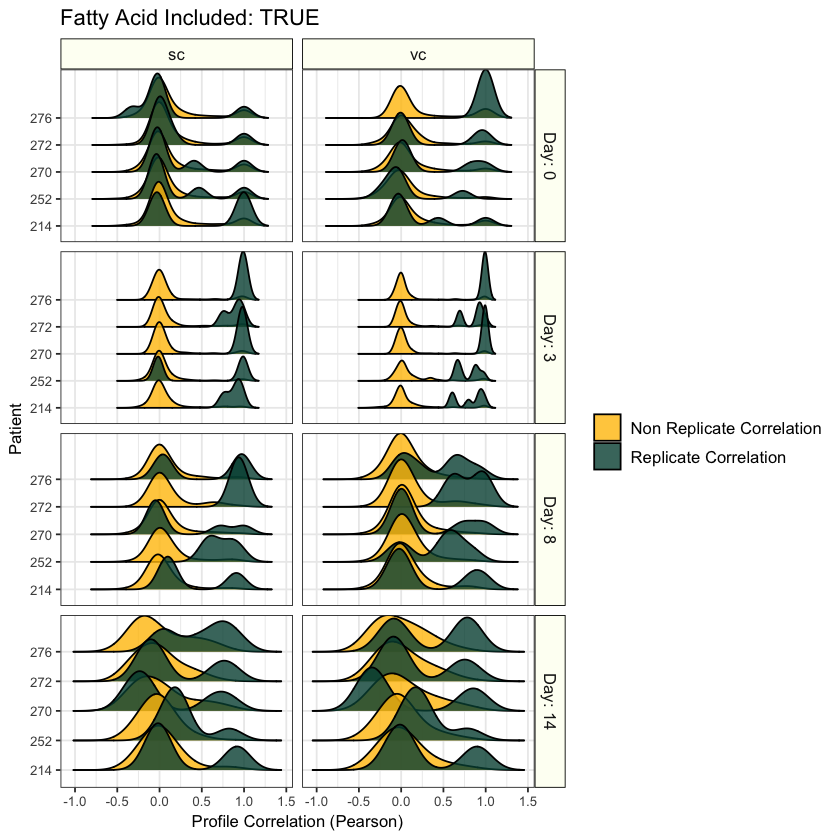

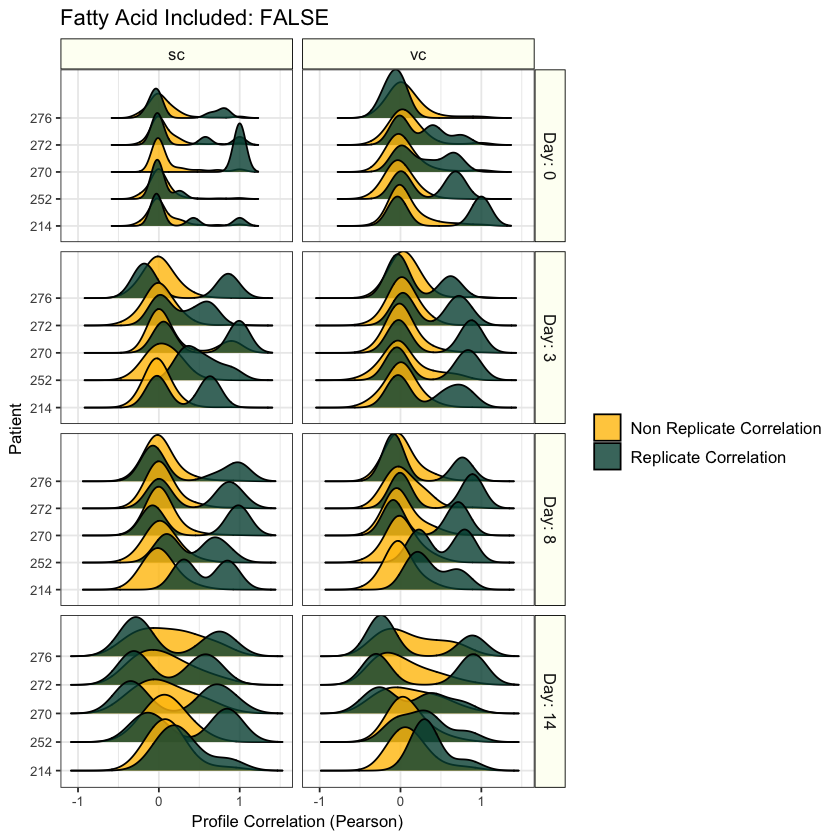

In [18]:
append_day <- function(string) paste("Day:", string)

for (fatty_acid in unique(full_plot_ready$Metadata_FFA)) {
    full_plot_subset_df <- full_plot_ready %>%
        dplyr::filter(Metadata_FFA == fatty_acid)
    
    cor_gg <- ggplot(full_plot_subset_df,
                     aes(x = pearson_cor,
                         y = as.factor(Metadata_patient),
                         fill = null_data)) +
        geom_density_ridges(alpha = 0.8) +
        ylab("Patient") +
        xlab("Profile Correlation (Pearson)") +
        theme_bw() +
        ggtitle(paste("Fatty Acid Included:", as.logical(as.numeric(fatty_acid)))) +
        facet_grid(Metadata_diff_day~Metadata_cell_line,
                   scales="free_y",
                   labeller = labeller(Metadata_diff_day = as_labeller(append_day))) +
        scale_fill_manual(name = "",
                          values = c("#FFC107", "#004D40")) +
        theme(axis.text.y = element_text(size = 8),
              axis.text.x = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 10),
              strip.text = element_text(size = 10),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))
    
    print(cor_gg)
    
    file_base <- file.path("figures", paste0(batch_id, "_replicate_correlation_fattyacid_", fatty_acid))
    for (extension in c('.png', '.pdf')) {
        ggsave(cor_gg,
               filename = paste0(file_base, extension),
               height = 10,
               width = 8)
    }
}

In [19]:
full_plot_group_df = full_plot_ready %>%
    dplyr::filter(pair_b == 1)

table(full_plot_group_df$null_data, full_plot_group_df$within_group_cor)

                           
                              0   1
  Non Replicate Correlation 383   0
  Replicate Correlation       0   6

## Step 5: Perform KS Test Against Distributions

In [20]:
# Perform KS tests between real and null distributions
all_results <- list()
for (group_id in unique(full_plot_ready$pair_b)) {
    full_plot_group_df = full_plot_ready %>%
        dplyr::filter(pair_b == group_id)

    replicate_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_cor == 1)
    null_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_cor == 0)

    ks_result = ks.test(x = replicate_corr_df$pearson_cor,
                        y = null_corr_df$pearson_cor,
                        alternative = "less")

    k_stat = as.numeric(ks_result$statistic)
    k_p = as.numeric(ks_result$p.value)
    all_results[[group_id]] <- c(group_id, k_stat, k_p, -log10(k_p), nrow(replicate_corr_df))
}

ks_result_df <- dplyr::as_tibble(do.call(rbind, all_results))
colnames(ks_result_df) <- c("group_id", "ks_stat", "ks_p_value", "ks_log_10_p", "num_replicates")

ks_result_df <- ks_result_df %>% dplyr::arrange(desc(as.numeric(paste(ks_log_10_p))))

dim(ks_result_df)
head(ks_result_df)

[1] 80  5

group_id,ks_stat,ks_p_value,ks_log_10_p,num_replicates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
31,0.9850000,9.306699e-06,5.031204,6
62,0.9610092,1.658969e-05,4.780162,6
78,0.9527559,1.999755e-05,4.699023,6
17,0.9565217,2.013052e-05,4.696145,6
38,0.9515220,2.056891e-05,4.686789,6
22,0.9483945,2.210589e-05,4.655492,6


In [21]:
ks_result_df$group_id <- as.numeric(ks_result_df$group_id)

final_results_df <- full_plot_ready %>%
    dplyr::left_join(ks_result_df,
                     by = c("pair_b" = "group_id")) %>%
    dplyr::group_by(
        Metadata_cell_line,
        Metadata_patient,
        Metadata_FFA,
        Metadata_diff_day
    ) %>%
    dplyr::mutate(
        median_cell_ks = median(ks_stat)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(
        Metadata_cell_line,
        Metadata_patient,
        Metadata_FFA,
        Metadata_diff_day,
        ks_stat,
        ks_p_value
    ) %>%
    dplyr::distinct()

head(final_results_df, 2)

Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,ks_stat,ks_p_value
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
vc,276,1,0,0.8506151,1.855934e-04
sc,270,0,0,0.9565217,2.013052e-05


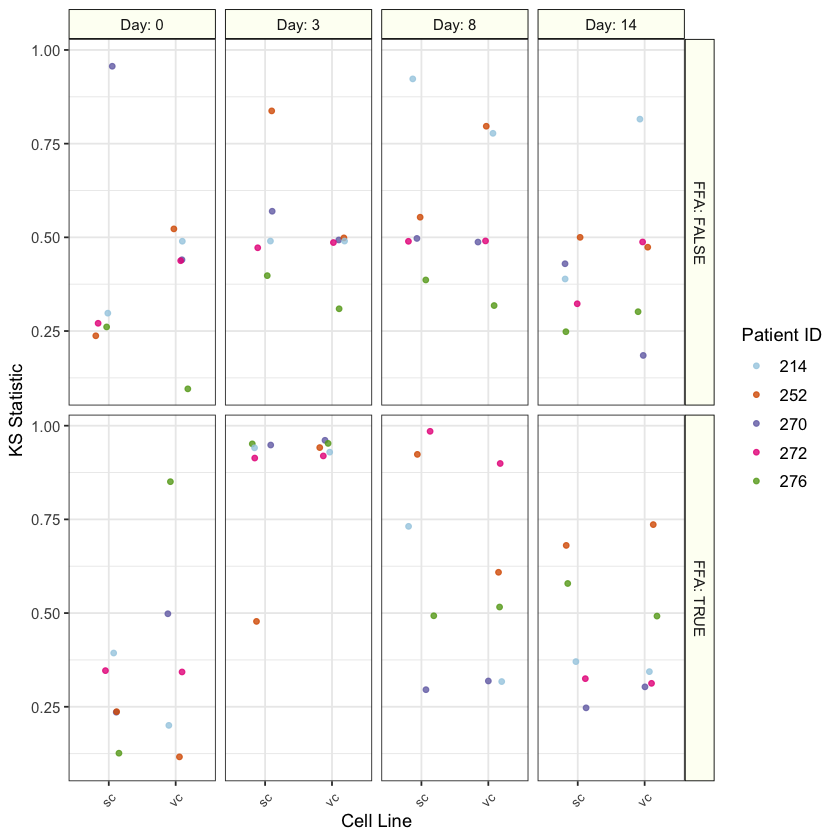

In [22]:
append_ffa <- function(string) paste("FFA:", as.logical(as.numeric(string)))

ks_test_gg <- ggplot(final_results_df) +
    geom_jitter(aes(y = ks_stat,
                    x = as.factor(Metadata_cell_line),
                    color = as.factor(Metadata_patient)),
                size = 1.25,
                height = 0,
                width = 0.2,
                alpha = 0.8) +
    scale_color_manual(name = "Patient ID",
                       values = c("#a6cee3",
                                  "#d95f02",
                                  "#7570b3",
                                  "#e7298a",
                                  "#66a61e")) +
    facet_grid(Metadata_FFA~Metadata_diff_day,
               scales = "free_x",
               labeller = labeller(Metadata_FFA = as_labeller(append_ffa),
                                   Metadata_diff_day = as_labeller(append_day))) +
    xlab("Cell Line") +
    ylab("KS Statistic") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 9),
          axis.text.x = element_text(size = 8, angle = 45, vjust = 0.5),
          axis.title = element_text(size = 11),
          legend.text = element_text(size = 10),
          strip.text = element_text(size = 9),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

ks_test_gg

In [23]:
file_base <- file.path("figures", paste0("replicate_correlation_kstest", "_", batch_id))
for (extension in c('.png', '.pdf')) {
    ggsave(ks_test_gg,
           filename = paste0(file_base, extension),
           height = 4,
           width = 6)
}